<div align="center">

# Instituto Tecnológico y de Estudios Superiores de Monterrey

**Septiembre–Diciembre 2025**
**Maestría en Inteligencia Artificial Aplicada**

## Avance 4

**Modelos alternativos**

---

### Equipo académico

|                  | **Nombre**                            |
| ---------------- | ------------------------------------- |
| Profesor Titular | Dra. Grettel Barceló Alonso           |
| Asesora          | Dra. Ludivina Facundo Flores          |
| Tutor            | Mtra. Verónica Sandra Guzmán de Valle |
| Sponsor          | Dr. Jesús Arturo Pérez Díaz           |

---

### Proyecto Integrador

**TC5035.10**

---

### Integrantes

| **Nombre**                        | **Matrícula** |
| --------------------------------- | ------------- |
| Christopher Adolfo Orduña De León | A01795372     |
| Miguel Ángel Paredes Gutiérrez    | A01794138     |
| Carlos Mariano Ramírez Amaya      | A01795036     |

**Fecha:** 19 de Octubre del 2025

</div>


In [1]:
import warnings

warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timezone
import os
from copy import deepcopy
import random
import math
import json

import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

PATH = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\data\processed\Filtrado_Mayo_28_2025_output.parquet'

DATA_DIR = r"C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection"
CKPT_DIR = f"{DATA_DIR}/models/checkpoints"
FIG_DIR = f"{DATA_DIR}/reports/figures"
REP_DIR = f"{DATA_DIR}/reports"
MOD_DIR = f"{DATA_DIR}/models"

# Ventanas del evento y testigos (UTC)
EVENT_START = pd.Timestamp("2025-05-28 04:08:00", tz="UTC")
EVENT_END   = pd.Timestamp("2025-05-28 04:37:00", tz="UTC")
WITNESS_BEFORE = (EVENT_START - pd.Timedelta("30min"), EVENT_START)
WITNESS_AFTER  = (EVENT_END, EVENT_END + pd.Timedelta("30min"))

# Semillas y dispositivo
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

df = pd.read_parquet(PATH, engine="pyarrow")
print("Shape: ", df.shape)
print("Columnas:", list(df.columns))
display(df.head(5))

Shape:  (316313, 19)
Columnas: ['time', 'collector', 'peer_asn', 'peer_ip', 'type', 'prefix', 'next_hop', 'as_path', 'origin', 'as_path_length', 'secs_between_announcements', 'unique_as_in_path', 'as_path_length_diff_A', 'as_path_length_diff_A_abs', 'origin_at_time_nuniq', 'MOAS', 'as_path_embedding', 'prev_embedding', 'cosine_distance_prev_A']


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


# GRU

## Load and Preprocess Data

In [2]:
# Filter valid announcements
df_filtered = df[
    (df['type'] == 'A') & 
    (df['as_path_embedding'].notna())
].sort_values('time').reset_index(drop=True)

print(f'Filtered dataset shape: {df_filtered.shape}')
print(f'Percentage retained: {100 * len(df_filtered) / len(df):.2f}%')

Filtered dataset shape: (303271, 19)
Percentage retained: 95.88%


## Selected Features:
1. **AS Path Embedding** → PCA to 49 components (95% variance)
2. **as_path_length_diff_A** → High CV (96.2)
3. **secs_between_announcements** → Temporal patterns
4. **cosine_distance_prev_A** → Route similarity

In [3]:
# Extract embeddings and apply PCA
embeddings = np.stack(df_filtered['as_path_embedding'].to_numpy())
print(f'Original embedding shape: {embeddings.shape}')

# Apply PCA
pca = PCA(n_components=49, random_state=42)
embeddings_reduced = pca.fit_transform(embeddings)

print(f'Reduced embedding shape: {embeddings_reduced.shape}')
print(f'Explained variance: {pca.explained_variance_ratio_.sum():.4f}')

Original embedding shape: (303271, 384)
Reduced embedding shape: (303271, 49)
Explained variance: 0.9503


In [4]:
# Extract and scale scalar features
scalar_features = [
    'as_path_length_diff_A',
    'secs_between_announcements',
    'cosine_distance_prev_A'
]

df_scalars = df_filtered[scalar_features].fillna(0)

scaler_diff = MinMaxScaler(feature_range=(-1, 1))
scaler_secs = MinMaxScaler(feature_range=(0, 1))
scaler_cos = MinMaxScaler(feature_range=(0, 1))

scalars_scaled = np.column_stack([
    scaler_diff.fit_transform(df_scalars[['as_path_length_diff_A']]),
    scaler_secs.fit_transform(df_scalars[['secs_between_announcements']]),
    scaler_cos.fit_transform(df_scalars[['cosine_distance_prev_A']])
])

print(f'Scaled scalars shape: {scalars_scaled.shape}')

Scaled scalars shape: (303271, 3)


In [5]:
# Combine features
X_combined = np.hstack([embeddings_reduced, scalars_scaled]).astype(np.float32)

print(f'Combined feature matrix shape: {X_combined.shape}')
print(f'Total features: {X_combined.shape[1]} (49 PCA + 3 scalars)')

Combined feature matrix shape: (303271, 52)
Total features: 52 (49 PCA + 3 scalars)


## Create Sequences for GRU

Convert time-series data into sequences of length 10.

In [6]:
def create_sequences(data, seq_length=10, stride=1):
    sequences = []
    for i in range(0, len(data) - seq_length + 1, stride):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

SEQ_LENGTH = 10
STRIDE = 1

X_sequences = create_sequences(X_combined, seq_length=SEQ_LENGTH, stride=STRIDE)

print(f'Sequences shape: {X_sequences.shape}')
print(f'  - Number of sequences: {X_sequences.shape[0]}')
print(f'  - Sequence length: {X_sequences.shape[1]}')
print(f'  - Features per time step: {X_sequences.shape[2]}')

Sequences shape: (303262, 10, 52)
  - Number of sequences: 303262
  - Sequence length: 10
  - Features per time step: 52


## Train/Validation/Test Split

In [7]:
N = len(X_sequences)
idx_train = int(N * 0.7)
idx_val = int(N * 0.85)

X_train = X_sequences[:idx_train]
X_val = X_sequences[idx_train:idx_val]
X_test = X_sequences[idx_val:]

print(f'Train set: {X_train.shape}')
print(f'Validation set: {X_val.shape}')
print(f'Test set: {X_test.shape}')

Train set: (212283, 10, 52)
Validation set: (45489, 10, 52)
Test set: (45490, 10, 52)


In [8]:
# Convert to PyTorch tensors and create DataLoaders
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float()

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)

BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f'Train batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Train batches: 830
Validation batches: 178
Test batches: 178


## GRU Autoencoder Model

In [9]:
class GRUAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32, num_layers=2, dropout=0.2):
        super(GRUAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        # Encoder GRU
        self.encoder_gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Encoder to latent
        self.encoder_fc = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim),
            nn.Tanh()
        )
        
        # Latent to decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder GRU
        self.decoder_gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        _, hidden = self.encoder_gru(x)
        hidden_last = hidden[-1]
        latent = self.encoder_fc(hidden_last)
        return latent
    
    def decode(self, latent, seq_len):
        batch_size = latent.size(0)
        decoder_hidden = self.decoder_fc(latent)
        decoder_input = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)
        decoder_output, _ = self.decoder_gru(decoder_input)
        output = self.output_layer(decoder_output)
        return output
    
    def forward(self, x):
        seq_len = x.size(1)
        latent = self.encode(x)
        reconstructed = self.decode(latent, seq_len)
        return reconstructed, latent

In [10]:
# Initialize model
INPUT_DIM = X_combined.shape[1]
HIDDEN_DIM = 128
LATENT_DIM = 16
NUM_LAYERS = 2
DROPOUT = 0.2

model = GRUAutoencoder(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    latent_dim=LATENT_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

print(model)
print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}')

GRUAutoencoder(
  (encoder_gru): GRU(52, 128, num_layers=2, batch_first=True, dropout=0.2)
  (encoder_fc): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): Tanh()
  )
  (decoder_fc): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
  )
  (decoder_gru): GRU(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=128, out_features=52, bias=True)
)

Total parameters: 378,052


## Training Function

In [ ]:
def train_gru_autoencoder(
    model, train_loader, val_loader, optimizer, criterion, device,
    max_epochs=50, patience=7, min_delta=1e-6,
    ckpt_dir='checkpoints', ckpt_name='best_gru_model.pt', verbose=True
):
    os.makedirs(ckpt_dir, exist_ok=True)
    
    best_val_loss = float('inf')
    wait = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(1, max_epochs + 1):
        # Training
        model.train()
        train_loss_sum = 0.0
        n_train = 0
        
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            reconstructed, latent = model(xb)
            loss = criterion(reconstructed, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss_sum += loss.item() * xb.size(0)
            n_train += xb.size(0)
        
        train_loss = train_loss_sum / n_train
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss_sum = 0.0
        n_val = 0
        
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                reconstructed, _ = model(xb)
                loss = criterion(reconstructed, yb)
                val_loss_sum += loss.item() * xb.size(0)
                n_val += xb.size(0)
        
        val_loss = val_loss_sum / n_val
        val_losses.append(val_loss)
        
        if verbose:
            print(f'[Epoch {epoch:03d}] train_loss={train_loss:.6f}  val_loss={val_loss:.6f}')
        
        # Early stopping
        if (best_val_loss - val_loss) > min_delta:
            best_val_loss = val_loss
            wait = 0
            torch.save(model, os.path.join(ckpt_dir, ckpt_name))
            if verbose:
                print(f'✅ Best model saved')
        else:
            wait += 1
            if verbose:
                print(f'⚠️  No improvement ({wait}/{patience})')
            
            if wait >= patience:
                if verbose:
                    print(f'⏹️ Early stopping at epoch {epoch}')
                break
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'best_model_path': os.path.join(ckpt_dir, ckpt_name)
    }

## Train the Model

In [12]:
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

history = train_gru_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_epochs=50,
    patience=7,
    ckpt_dir='../models/checkpoints',
    ckpt_name='best_gru_model.pt',
    verbose=True
)

print(f'\nTraining complete!')
print(f'Best validation loss: {history["best_val_loss"]:.6f}')

[Epoch 001] train_loss=0.004186  val_loss=0.004405
✅ Best model saved
[Epoch 002] train_loss=0.003717  val_loss=0.004191
✅ Best model saved
[Epoch 003] train_loss=0.003585  val_loss=0.004111
✅ Best model saved
[Epoch 004] train_loss=0.003593  val_loss=0.004109
✅ Best model saved
[Epoch 005] train_loss=0.003457  val_loss=0.004125
⚠️  No improvement (1/7)
[Epoch 006] train_loss=0.003408  val_loss=0.004030
✅ Best model saved
[Epoch 007] train_loss=0.003409  val_loss=0.003983
✅ Best model saved
[Epoch 008] train_loss=0.003341  val_loss=0.003984
⚠️  No improvement (1/7)
[Epoch 009] train_loss=0.003344  val_loss=0.003962
✅ Best model saved
[Epoch 010] train_loss=0.003307  val_loss=0.003961
✅ Best model saved
[Epoch 011] train_loss=0.003311  val_loss=0.003974
⚠️  No improvement (1/7)
[Epoch 012] train_loss=0.003249  val_loss=0.003959
✅ Best model saved
[Epoch 013] train_loss=0.003272  val_loss=0.003967
⚠️  No improvement (1/7)
[Epoch 014] train_loss=0.003259  val_loss=0.003980
⚠️  No improvem

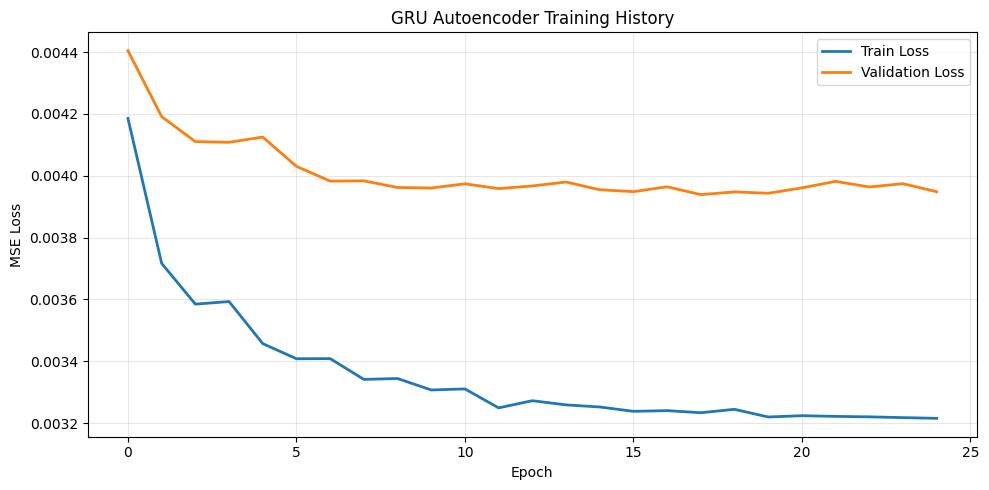

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('GRU Autoencoder Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [14]:
# Load best model
best_model = torch.load(history['best_model_path'], weights_only=False)
best_model.eval()

# Calculate reconstruction errors
test_errors = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        reconstructed, _ = best_model(xb)
        mse = ((reconstructed - yb) ** 2).mean(dim=(1, 2))
        test_errors.append(mse.cpu().numpy())

test_errors = np.concatenate(test_errors)

print(f'Test set reconstruction errors:')
print(f'  Mean: {test_errors.mean():.6f}')
print(f'  Std: {test_errors.std():.6f}')
print(f'  Min: {test_errors.min():.6f}')
print(f'  Max: {test_errors.max():.6f}')

Test set reconstruction errors:
  Mean: 0.004927
  Std: 0.001956
  Min: 0.000597
  Max: 0.019631


## Anomaly Detection Visualization

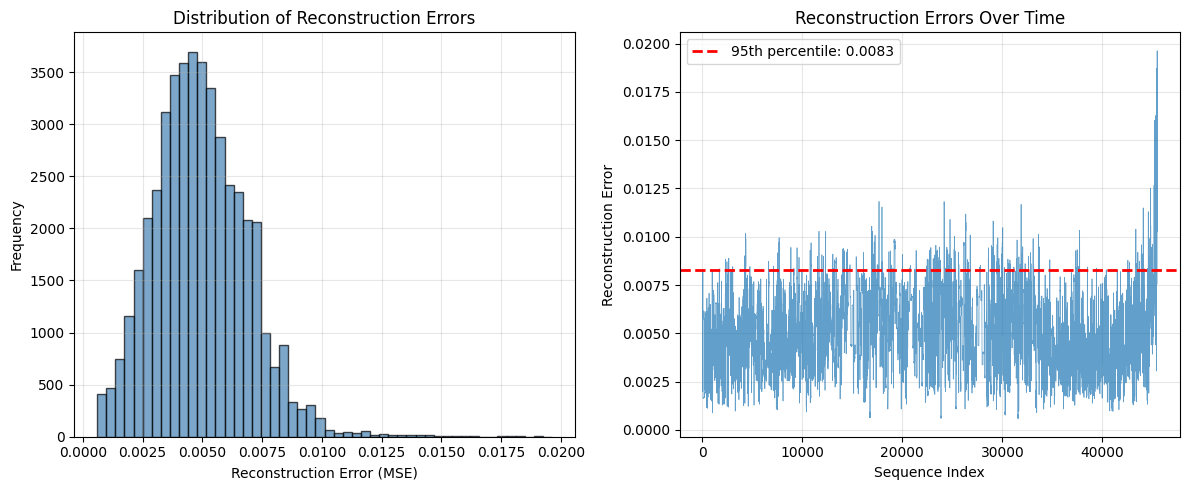


Anomalies detected: 2275 / 45490 (5.00%


In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(test_errors, linewidth=0.5, alpha=0.7)
threshold = np.percentile(test_errors, 95)
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {threshold:.4f}')
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

anomalies = test_errors > threshold
print(f'\nAnomalies detected: {anomalies.sum()} / {len(test_errors)} ({100*anomalies.sum()/len(test_errors):.2f}%')

In [16]:
results_summary = {
    'model_type': 'GRU Autoencoder',
    'dataset': 'Filtrado_Mayo_28_2025_output.parquet',
    'total_samples': len(df_filtered),
    'sequence_length': SEQ_LENGTH,
    'num_sequences': len(X_sequences),
    'input_dim': INPUT_DIM,
    'hidden_dim': HIDDEN_DIM,
    'latent_dim': LATENT_DIM,
    'pca_components': 49,
    'selected_features': ['as_path_embedding (PCA)', 'as_path_length_diff_A', 'secs_between_announcements', 'cosine_distance_prev_A'],
    'best_val_loss': history['best_val_loss'],
    'test_mean_error': float(test_errors.mean()),
    'test_std_error': float(test_errors.std())
}

print('='*80)
print('RESULTS SUMMARY')
print('='*80)
for key, value in results_summary.items():
    print(f'{key}: {value}')
print('='*80)

RESULTS SUMMARY
model_type: GRU Autoencoder
dataset: Filtrado_Mayo_28_2025_output.parquet
total_samples: 303271
sequence_length: 10
num_sequences: 303262
input_dim: 52
hidden_dim: 128
latent_dim: 16
pca_components: 49
selected_features: ['as_path_embedding (PCA)', 'as_path_length_diff_A', 'secs_between_announcements', 'cosine_distance_prev_A']
best_val_loss: 0.003939216859942847
test_mean_error: 0.004926916677504778
test_std_error: 0.001956472173333168


# LSTM

In [2]:
# Auto-detección de unidad de epoch
if pd.api.types.is_integer_dtype(df["time"]) or pd.api.types.is_float_dtype(df["time"]):
    unit = "ms" if (df["time"].dropna().astype(float) > 1e12).mean() > 0.5 else "s"
    df["time"] = pd.to_datetime(df["time"], unit=unit, utc=True, errors="coerce")
elif df["time"].dtype == "datetime64[ns]":
    df["time"] = df["time"].dt.tz_localize("UTC")

# Filtro por tipo si existe
if "type" in df.columns:
    before = len(df)
    df = df[df["type"]=="A"].copy()
    print(f"Filtro type=='A': {before} -> {len(df)} filas")
else:
    print("Aviso: no existe columna 'type'; se omite filtro por tipo.")

print("Rango temporal corregido:", df["time"].min(), "→", df["time"].max())
df.head(3)

Filtro type=='A': 316313 -> 303271 filas
Rango temporal corregido: 2025-05-28 03:40:21.746663094+00:00 → 2025-05-28 05:06:56.066126108+00:00


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,2025-05-28 04:08:41.140341997+00:00,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,2025-05-28 04:08:46.707509041+00:00,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,2025-05-28 04:08:47.864945889+00:00,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625


In [3]:
# [4] Etiquetado vectorizado de ventanas: testigos (antes/después) y evento; filtrado a ventanas de interés.
m_before = (df["time"] >= WITNESS_BEFORE[0]) & (df["time"] <  WITNESS_BEFORE[1])
m_event  = (df["time"] >= EVENT_START)        & (df["time"] <= EVENT_END)
m_after  = (df["time"] >  WITNESS_AFTER[0])   & (df["time"] <= WITNESS_AFTER[1])

choices = np.select([m_before, m_event, m_after],
                    ["witness_before", "event", "witness_after"],
                    default="out_of_scope")
df["window_label"] = pd.Categorical(choices,
                                    categories=["witness_before","event","witness_after","out_of_scope"],
                                    ordered=False)

print("Conteos preliminares:", df["window_label"].value_counts().to_dict())

# Filtrar ventanas de interés y ordenar
df = df[df["window_label"]!="out_of_scope"].copy()
df = df.sort_values(["prefix","time"]).reset_index(drop=True)
df["secs_between_announcements"] = pd.to_numeric(df["secs_between_announcements"], errors="coerce").fillna(0.0)
print("Filas post-filtrado:", len(df))
df.head(3)

Conteos preliminares: {'event': 275808, 'witness_before': 20951, 'witness_after': 6512, 'out_of_scope': 0}
Filas post-filtrado: 303271


,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A,window_label
0,2025-05-28 04:08:41.140341997+00:00,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,0.000000,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN,event
1,2025-05-28 04:08:46.707509041+00:00,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881,event
2,2025-05-28 04:08:47.864945889+00:00,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625,event


In [4]:
# [5] Parseo robusto de 'as_path_embedding'
def to_vec_safe(x):
    if isinstance(x, np.ndarray) and x.ndim == 1 and x.size > 0:
        return x.astype(np.float32)
    if isinstance(x, (list, tuple)):
        arr = np.array(x, dtype=np.float32)
        return arr if arr.ndim == 1 and arr.size > 0 else None
    if isinstance(x, str):
        s = x.strip()
        for parser in (json.loads, ast.literal_eval):
            try:
                val = parser(s)
                arr = np.array(val, dtype=np.float32)
                if arr.ndim == 1 and arr.size > 0:
                    return arr
            except Exception:
                continue
    return None

emb_series = df["as_path_embedding"].apply(to_vec_safe)
valid_mask = emb_series.apply(lambda v: isinstance(v, np.ndarray) and v.ndim==1 and v.size>0)
print("Embeddings válidos:", valid_mask.sum(), "/", len(emb_series))

if valid_mask.sum() == 0:
    raise ValueError("No se encontraron embeddings válidos en 'as_path_embedding'. Regenera embeddings en Avance 2 y reintenta.")

# Unificar dimensión usando la mediana de longitudes y filtrar al tamaño modal
lengths = emb_series[valid_mask].apply(len).values
emb_dim = int(np.median(lengths))
emb_series = emb_series[valid_mask & (emb_series.apply(len)==emb_dim)]
df = df.loc[emb_series.index].copy()
X_emb = np.stack(emb_series.values).astype(np.float32)

# Normalización L2 de embeddings
norms = np.linalg.norm(X_emb, axis=1, keepdims=True) + 1e-8
X_emb = X_emb / norms
print("emb_dim:", emb_dim, "| X_emb:", X_emb.shape)

Embeddings válidos: 303271 / 303271
emb_dim: 384 | X_emb: (303271, 384)


In [5]:
# [6] Escalado de 'secs_between_announcements' (fit en testigos) y concatenación con embeddings.
witness_mask = df["window_label"].isin(["witness_before","witness_after"]).values
scaler_secs = MinMaxScaler()
secs_arr = df[["secs_between_announcements"]].astype(np.float32).values
scaler_secs.fit(secs_arr[witness_mask])
secs_scaled = scaler_secs.transform(secs_arr).astype(np.float32)

X_all = np.concatenate([X_emb, secs_scaled], axis=1).astype(np.float32)
input_dim = X_all.shape[1]
print("Input dim:", input_dim, "| X_all:", X_all.shape)

Input dim: 385 | X_all: (303271, 385)


In [6]:
# [7] Resample a 5s por 'prefix' con forward-fill; acoplar features al DataFrame y rearmar matriz.
RESAMPLE_RULE = "5s"

def resample_prefix(g):
    g = g.sort_values("time").set_index("time").resample(RESAMPLE_RULE).ffill()
    g["prefix"] = g["prefix"].ffill()
    g["collector"] = g["collector"].ffill()
    g["window_label"] = g["window_label"].ffill()
    return g.reset_index()

feat_df = pd.DataFrame(X_all, index=df.index)
df_rs = pd.concat([df.reset_index(drop=True), feat_df.reset_index(drop=True)], axis=1)
df_rs = df_rs.groupby("prefix", group_keys=False).apply(resample_prefix)

# Identificar columnas de features (asumimos que son las últimas X_all.shape[1] columnas)
feat_cols = df_rs.columns[-X_all.shape[1]:].tolist()
X_mat = df_rs[feat_cols].astype(np.float32).values
print("Resampled shape:", df_rs.shape, "| X_mat:", X_mat.shape)

Resampled shape: (595965, 405) | X_mat: (595965, 385)


In [7]:
# [8] Construcción de secuencias LSTM con ventana deslizante.
SEQ_LEN = 24  # 24*5s = 120s
STRIDE = 1

sequences, labels, times_end, prefixes = [], [], [], []

for pfx, g in df_rs.groupby("prefix"):
    g = g.sort_values("time")
    Xp = g[feat_cols].to_numpy(dtype=np.float32)
    wl = g["window_label"].values
    tt = g["time"].values
    if len(g) < SEQ_LEN:
        continue
    for st in range(0, len(g)-SEQ_LEN+1, STRIDE):
        ed = st + SEQ_LEN
        sequences.append(Xp[st:ed])
        labels.append(wl[ed-1])
        times_end.append(tt[ed-1])
        prefixes.append(pfx)

if len(sequences)==0:
    raise ValueError("No se pudieron construir secuencias. Revisa RESAMPLE_RULE, SEQ_LEN y disponibilidad por prefix.")

X_seq = np.stack(sequences).astype(np.float32)
labels = np.array(labels)
times_end = np.array(times_end)
prefixes = np.array(prefixes)

print("X_seq:", X_seq.shape, "| labels:", np.unique(labels, return_counts=True))

X_seq: (505123, 24, 385) | labels: (array(['event', 'witness_after', 'witness_before'], dtype='<U14'), array([444841,  11865,  48417]))


In [8]:
# [9] Splits: train/val con testigos; test(event) y testigos para FPR.
idx_witness = np.where(np.isin(labels, ["witness_before","witness_after"]))[0]
idx_event = np.where(labels=="event")[0]

iw_sorted = idx_witness[np.argsort(times_end[idx_witness])]
cut = int(0.8 * len(iw_sorted)) if len(iw_sorted)>0 else 0
train_idx = iw_sorted[:cut]
val_idx = iw_sorted[cut:]
test_event_idx = idx_event

test_wb_idx = np.where(labels=="witness_before")[0]
test_wa_idx = np.where(labels=="witness_after")[0]

def take(idx):
    return (X_seq[idx] if len(idx)>0 else np.zeros((0, SEQ_LEN, X_seq.shape[2]), dtype=np.float32)),            (labels[idx] if len(idx)>0 else np.array([])),            (times_end[idx] if len(idx)>0 else np.array([])),            (prefixes[idx] if len(idx)>0 else np.array([]))

X_train, y_train, t_train, p_train = take(train_idx)
X_val, y_val, t_val, p_val = take(val_idx)
X_test_event, y_te, t_te, p_te = take(test_event_idx)
X_test_wb, y_wb, t_wb, p_wb = take(test_wb_idx)
X_test_wa, y_wa, t_wa, p_wa = take(test_wa_idx)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test(event):", X_test_event.shape)

Train: (48225, 24, 385) Val: (12057, 24, 385) Test(event): (444841, 24, 385)


In [11]:
# [10] DataLoaders: datasets y loaders con pin_memory.
class SeqDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i]

BATCH = 256
num_workers = 0

dl_train = DataLoader(SeqDataset(X_train), batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_val   = DataLoader(SeqDataset(X_val),   batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_te    = DataLoader(SeqDataset(X_test_event), batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_wb    = DataLoader(SeqDataset(X_test_wb), batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=num_workers)
dl_wa    = DataLoader(SeqDataset(X_test_wa), batch_size=BATCH, shuffle=False, pin_memory=True, num_workers=num_workers)

input_dim = X_train.shape[2] if X_train.size else (X_seq.shape[2] if X_seq.size else 0)
print("Input dim (LSTM):", input_dim)

Input dim (LSTM): 385


In [13]:
# [11] Modelo LSTM Autoencoder: encoder-decoder con proyección de salida.
class LSTMAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.to_latent = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.LSTM(latent_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.to_out = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        enc_out, _ = self.encoder(x)         # [B,T,H]
        last_h = enc_out[:, -1, :]           # [B,H]
        z = self.to_latent(last_h)           # [B,Z]
        T = x.size(1)
        z_rep = z.unsqueeze(1).repeat(1, T, 1)  # [B,T,Z]
        dec_out, _ = self.decoder(z_rep)        # [B,T,H]
        y_hat = self.to_out(dec_out)            # [B,T,D]
        return y_hat, z

if input_dim == 0:
    raise ValueError("input_dim=0: no hay features para el modelo. Revisa pasos previos.")
model = LSTMAE(input_dim=input_dim, hidden_dim=128, latent_dim=64, num_layers=2, dropout=0.1).to(device)
crit = nn.MSELoss(reduction="mean")
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [14]:
# [12] Entrenamiento con Early Stopping, grad clipping y checkpoints.
EPOCHS = 100
PATIENCE = 10
MIN_DELTA = 1e-5
best_val = float("inf")
no_improve = 0

def run_epoch(dloader, train=True):
    model.train(train)
    total = 0.0; n = 0
    for xb in dloader:
        xb = xb.to(device)
        if train:
            opt.zero_grad(set_to_none=True)
        yhat, _ = model(xb)
        loss = crit(yhat, xb)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
        bs = xb.size(0)
        total += loss.item()*bs
        n += bs
    return total/max(n,1)

for ep in range(1, EPOCHS+1):
    tr = run_epoch(dl_train, train=True)
    vl = run_epoch(dl_val, train=False)
    print(f"Epoch {ep:03d} | train={tr:.6f} | val={vl:.6f}")
    if best_val - vl > MIN_DELTA:
        best_val = vl; no_improve = 0
        torch.save(model.state_dict(), os.path.join(CKPT_DIR, "best_lstm_model.pt"))
    else:
        no_improve += 1
    torch.save(model.state_dict(), os.path.join(CKPT_DIR, "last_lstm_model.pt"))
    if no_improve >= PATIENCE:
        print("Early stopping."); break

Epoch 001 | train=0.001014 | val=0.001265
Epoch 002 | train=0.000818 | val=0.001249
Epoch 003 | train=0.000810 | val=0.001236
Epoch 004 | train=0.000810 | val=0.001241
Epoch 005 | train=0.000810 | val=0.001244
Epoch 006 | train=0.000811 | val=0.001243
Epoch 007 | train=0.000810 | val=0.001243
Epoch 008 | train=0.000811 | val=0.001242
Epoch 009 | train=0.000809 | val=0.001241
Epoch 010 | train=0.000809 | val=0.001240
Epoch 011 | train=0.000809 | val=0.001240
Epoch 012 | train=0.000809 | val=0.001240
Epoch 013 | train=0.000809 | val=0.001240
Early stopping.


In [15]:
# [13] Evaluación: errores de reconstrucción por secuencia y resumen estadístico.
@torch.no_grad()
def reconstruction_errors(dloader):
    model.eval()
    errs = []
    for xb in dloader:
        xb = xb.to(device)
        yhat, _ = model(xb)
        e = ((yhat - xb)**2).mean(dim=(1,2)).detach().cpu().numpy()
        errs.append(e)
    if len(errs)==0: return np.array([])
    return np.concatenate(errs, axis=0)

err_train = reconstruction_errors(dl_train)
err_val   = reconstruction_errors(dl_val)
err_te    = reconstruction_errors(dl_te)
err_wb    = reconstruction_errors(dl_wb)
err_wa    = reconstruction_errors(dl_wa)

def summarize(name, arr):
    if arr.size==0: return {"name": name, "count": 0}
    return {"name": name, "count": int(arr.size),
            "mean": float(arr.mean()), "std": float(arr.std()),
            "p50": float(np.percentile(arr, 50)),
            "p90": float(np.percentile(arr, 90)),
            "p95": float(np.percentile(arr, 95)),
            "p99": float(np.percentile(arr, 99))}

summary = [summarize("train", err_train),
           summarize("val", err_val),
           summarize("test_event", err_te),
           summarize("test_witness_before", err_wb),
           summarize("test_witness_after", err_wa)]
summary

[{'name': 'train',
  'count': 48225,
  'mean': 0.0008800238138064742,
  'std': 0.0003053505497518927,
  'p50': 0.000830582226626575,
  'p90': 0.0014922417467460036,
  'p95': 0.0014922571135684848,
  'p99': 0.001492472249083221},
 {'name': 'val',
  'count': 12057,
  'mean': 0.001239772536791861,
  'std': 0.0005137996631674469,
  'p50': 0.0010182000696659088,
  'p90': 0.0020779420156031847,
  'p95': 0.002232609549537301,
  'p99': 0.0024434051010757685},
 {'name': 'test_event',
  'count': 444841,
  'mean': 0.0009726293501444161,
  'std': 0.00021016932441852987,
  'p50': 0.0009432049700990319,
  'p90': 0.0012289099395275116,
  'p95': 0.0014380302745848894,
  'p99': 0.0017026581335812807},
 {'name': 'test_witness_before',
  'count': 48417,
  'mean': 0.0008806919795460999,
  'std': 0.0003053028485737741,
  'p50': 0.0008306127274408937,
  'p90': 0.0014922417467460036,
  'p95': 0.0014922571135684848,
  'p99': 0.001492472249083221},
 {'name': 'test_witness_after',
  'count': 11865,
  'mean': 0.

In [16]:
# [14] Umbral p95 (train), TPR en evento y FPR en testigos.
if err_train.size>0:
    threshold = float(np.percentile(err_train, 95))
else:
    threshold = float("nan")

def rate(arr, thr):
    return float((arr > thr).mean()) if arr.size>0 and not math.isnan(thr) else float("nan")

metrics_core = {
    "threshold_p95_train": threshold,
    "TPR_event": rate(err_te, threshold),
    "FPR_witness_before": rate(err_wb, threshold),
    "FPR_witness_after": rate(err_wa, threshold),
}
metrics_core

{'threshold_p95_train': 0.0014922571135684848,
 'TPR_event': 0.03713911262675877,
 'FPR_witness_before': 0.04378627341636202,
 'FPR_witness_after': 0.3120101137800253}

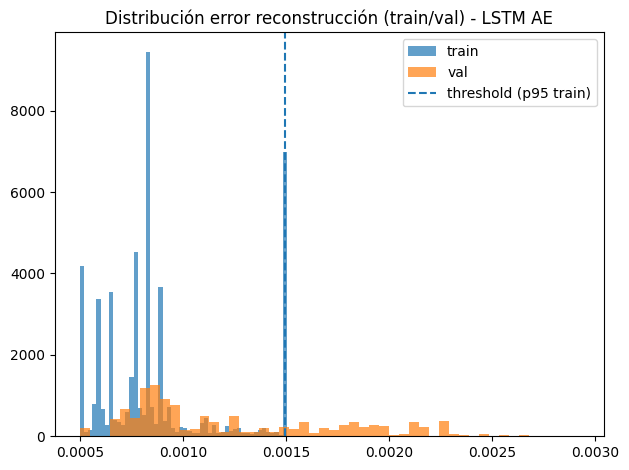

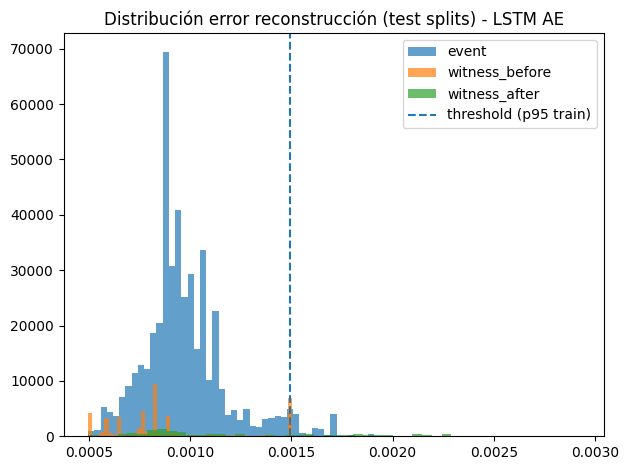

Figuras guardadas en: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/reports/figures


In [20]:
# [15] Figuras: histogramas de error y guardado.
plt.figure()
if err_train.size>0: plt.hist(err_train, bins=50, alpha=0.7, label="train")
if err_val.size>0:   plt.hist(err_val,   bins=50, alpha=0.7, label="val")
if not math.isnan(metrics_core["threshold_p95_train"]):
    plt.axvline(metrics_core["threshold_p95_train"], linestyle="--", label="threshold (p95 train)")
plt.title("Distribución error reconstrucción (train/val) - LSTM AE")
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "lstm_error_hist_train_val.png"));plt.show();
plt.figure()
if err_te.size>0: plt.hist(err_te, bins=50, alpha=0.7, label="event")
if err_wb.size>0: plt.hist(err_wb, bins=50, alpha=0.7, label="witness_before")
if err_wa.size>0: plt.hist(err_wa, bins=50, alpha=0.7, label="witness_after")
if not math.isnan(metrics_core["threshold_p95_train"]):
    plt.axvline(metrics_core["threshold_p95_train"], linestyle="--", label="threshold (p95 train)")
plt.title("Distribución error reconstrucción (test splits) - LSTM AE")
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "lstm_error_hist_tests.png"));plt.show(); plt.close()

print("Figuras guardadas en:", FIG_DIR)

In [21]:
# [16] Persistencia: guardar métricas y configuración del modelo.
out_metrics = {
    "summary": summary,
    "core": metrics_core,
    "model": {"type": "LSTM_AE", "input_dim": int(input_dim), "seq_len": int(SEQ_LEN),
              "hidden_dim": 128, "latent_dim": 64, "layers": 2, "dropout": 0.1},
    "data": {"resample": "5s",
             "event_start": str(EVENT_START), "event_end": str(EVENT_END),
             "witness_before": [str(WITNESS_BEFORE[0]), str(WITNESS_BEFORE[1])],
             "witness_after": [str(WITNESS_AFTER[0]), str(WITNESS_AFTER[1])],
             "paths": {"DATA_DIR": DATA_DIR, #"PARQUET": PARQUET,
                       "CKPT_DIR": CKPT_DIR, "FIG_DIR": FIG_DIR}},
}

with open(f"{REP_DIR}/metrics_lstm.json", "w") as f:
    json.dump(out_metrics, f, indent=2)

with open(f"{MOD_DIR}/lstm_config.json", "w") as f:
    json.dump(out_metrics["model"], f, indent=2)

print("Métricas guardadas en:", f"{REP_DIR}/metrics_lstm.json")
print("Config guardada en  :", f"{MOD_DIR}/lstm_config.json")

Métricas guardadas en: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/reports/metrics_lstm.json
Config guardada en  : C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/models/lstm_config.json


In [22]:
# [17] Resumen final: impresión de métricas clave.
print("=== Resumen LSTM AE ===")
print(json.dumps(metrics_core, indent=2))

=== Resumen LSTM AE ===
{
  "threshold_p95_train": 0.0014922571135684848,
  "TPR_event": 0.03713911262675877,
  "FPR_witness_before": 0.04378627341636202,
  "FPR_witness_after": 0.3120101137800253
}


In [23]:
# [Final] Mostrar resultados guardados del modelo LSTM
import json
from IPython.display import JSON, display

# Ruta al archivo de métricas
metrics_path = f"{REP_DIR}/metrics_lstm.json"

with open(metrics_path, "r") as f:
    results = json.load(f)

print("=== Núcleo de métricas (core) ===")
display(JSON(results["core"]))

print("\n=== Resumen estadístico por split ===")
display(JSON(results["summary"]))

print("\n=== Configuración del modelo ===")
display(JSON(results["model"]))

print("\n=== Información de datos ===")
display(JSON(results["data"]))

print("\n📊 Figuras generadas:")
print(f"- Train/Val: {FIG_DIR}/lstm_error_hist_train_val.png")
print(f"- Test Splits: {FIG_DIR}/lstm_error_hist_tests.png")

print("\n📦 Checkpoints guardados:")
print(f"- Best model: {CKPT_DIR}/best_lstm_model.pt")
print(f"- Last model: {CKPT_DIR}/last_lstm_model.pt")

=== Núcleo de métricas (core) ===


<IPython.core.display.JSON object>


=== Resumen estadístico por split ===


<IPython.core.display.JSON object>


=== Configuración del modelo ===


<IPython.core.display.JSON object>


=== Información de datos ===


<IPython.core.display.JSON object>


📊 Figuras generadas:
- Train/Val: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/reports/figures/lstm_error_hist_train_val.png
- Test Splits: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/reports/figures/lstm_error_hist_tests.png

📦 Checkpoints guardados:
- Best model: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/models/checkpoints/best_lstm_model.pt
- Last model: C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection/models/checkpoints/last_lstm_model.pt


# Markov

In [2]:
df['prefix'].value_counts().sort_values(ascending=False)[:10].to_frame().reset_index()

,prefix,count
0,156.227.32.0/21,1974
1,103.199.103.0/24,727
2,103.86.46.0/24,705
3,103.86.47.0/24,702
4,103.86.44.0/24,701
5,103.86.45.0/24,701
6,116.204.170.0/24,681
7,116.204.169.0/24,679
8,116.204.171.0/24,677
9,137.59.18.0/24,655


In [3]:
prefix = '156.227.32.0/21'

prefix_df = df[df['prefix']==prefix]
display(prefix_df.head(3))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,NaN,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,36.512986,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,618.838053,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987


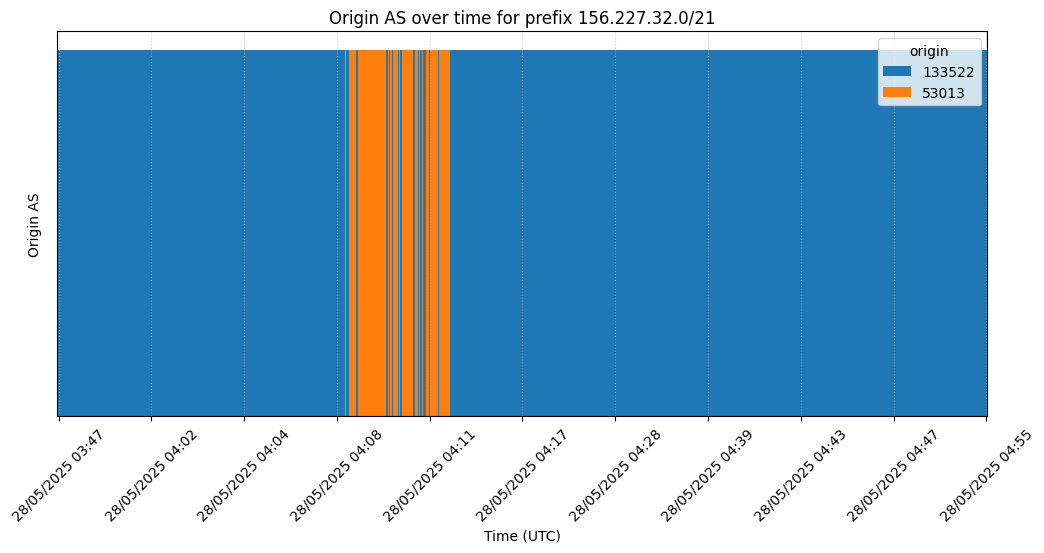

In [4]:
df_copy = df.copy()
df_copy['formatted_time'] = pd.to_datetime(df_copy['time'], unit='s', utc=True, errors='coerce')

target_prefix = prefix

df_target = df_copy[(df_copy['prefix'] == target_prefix) & (df_copy['type'] == 'A')].sort_values('formatted_time')

freq = '1s'

df_target = df_target.set_index('formatted_time').resample(freq)['origin'].last().dropna().reset_index()

df_counts = df_target.groupby([pd.Grouper(key='formatted_time', freq=freq), 'origin']).size().unstack(fill_value=0)

ax = df_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12,5),
    # Colormap='tab10',
    width=1.0
)

plt.title(f'Origin AS over time for prefix {target_prefix}', fontsize=12)
plt.xlabel('Time (UTC)')
plt.ylabel('Origin AS')
ax.set(yticklabels=[])
ax.tick_params(left=False)
plt.xticks(ticks=range(0, len(df_counts), max(1, len(df_counts)//10)),
           labels=[d.strftime('%d/%m/%Y %H:%M') for d in df_counts.index[::max(1, len(df_counts)//10)]],
           rotation=45)
plt.grid(True, axis='x', linestyle=':', alpha=0.6)

plt.show()

### Generar estados

Embeddings `AS_PATH` + `PREFIX`

In [6]:
def filter_by_utc_window(df, start_str, end_str):
    # Parseo como UTC
    start = datetime.strptime(start_str, "%Y-%m-%d %H:%M").replace(tzinfo=timezone.utc)
    end   = datetime.strptime(end_str, "%Y-%m-%d %H:%M").replace(tzinfo=timezone.utc)

    # A epoch seconds (enteros)
    start_s = int(start.timestamp())
    end_s   = int(end.timestamp())

    # Inicio inclusivo, fin exclusivo (ajusta según necesites)
    mask = (df["time"] >= start_s) & (df["time"] < end_s)
    return df.loc[mask].copy()

df_event = filter_by_utc_window(df=prefix_df,
                                start_str='2025-05-28 03:37', # Periodo antes
                                end_str='2025-05-28 04:07') # del evento de secuestro
display(df_event)

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,NaN,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,36.512986,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,618.838053,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987
1418113,1.748405e+09,route-views.eqix,57695,206.126.236.214,A,156.227.32.0/21,206.126.236.214,57695 60068 174 3491 150684 138195 133522,133522,7,0.494050,7,1.0,1.0,1,0,"[0.027108384, -0.035051804, -0.099397674, 0.01...","[-0.06269697, -0.04937925, 0.01215516, -0.0382...",0.406318
1418114,1.748405e+09,route-views.eqix,11039,206.126.236.172,A,156.227.32.0/21,206.126.236.172,11039 6461 3491 150684 138195 133522,133522,6,6.314879,6,-1.0,-1.0,1,0,"[-0.07119129, -0.025156064, -0.05836838, -0.02...","[0.027108384, -0.035051804, -0.099397674, 0.01...",0.247136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418647,1.748405e+09,route-views.ny,209823,206.82.105.109,W,156.227.32.0/21,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
1418648,1.748405e+09,route-views.eqix,6057,206.126.236.189,W,156.227.32.0/21,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
1418649,1.748405e+09,route-views.eqix,11039,206.126.236.172,W,156.227.32.0/21,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN
1418650,1.748405e+09,route-views.ny,398465,206.82.104.185,A,156.227.32.0/21,206.82.104.185,398465 7029 6461 3491 150684 138195 133522,133522,7,11.203748,7,0.0,0.0,1,0,"[-0.010729912, -0.04826849, -0.09244486, -0.01...","[-0.016531646, -0.07118929, -0.08040959, -0.02...",0.106572


In [7]:
EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDINGS_MODEL)

In [8]:
# Filtramos filas válidas
mask_valid = (
    df_event['prefix'].notna()
)

# Combinamos prefix + as_path
df_event['state_embedding'] = df_event['type'].astype(str) + " " + df_event['prefix'].astype(str) + " " + df_event['origin'].astype(str) + " " + df_event['as_path'].astype(str)

# Generamos embeddings solo para filas válidas
valid_texts = df_event.loc[mask_valid, 'state_embedding'].tolist()
embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

Batches: 100%|██████████| 17/17 [00:00<00:00, 36.58it/s]


In [9]:
for i, idx in enumerate(df_event.index[mask_valid]):
  df_event.at[idx, 'state_embedding'] = embeddings[i]

display(df_event.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A,state_embedding
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,NaN,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN,"[-0.0041357153, 0.013522448, -0.098932154, 0.0..."
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,36.512986,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257,"[-0.0039059862, 0.009959294, -0.08870342, 0.01..."
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,618.838053,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987,"[-0.009323231, 0.015897159, -0.069182985, 0.00..."
1418113,1.748405e+09,route-views.eqix,57695,206.126.236.214,A,156.227.32.0/21,206.126.236.214,57695 60068 174 3491 150684 138195 133522,133522,7,0.494050,7,1.0,1.0,1,0,"[0.027108384, -0.035051804, -0.099397674, 0.01...","[-0.06269697, -0.04937925, 0.01215516, -0.0382...",0.406318,"[0.0007613517, 0.0076228185, -0.09350564, 0.01..."
1418114,1.748405e+09,route-views.eqix,11039,206.126.236.172,A,156.227.32.0/21,206.126.236.172,11039 6461 3491 150684 138195 133522,133522,6,6.314879,6,-1.0,-1.0,1,0,"[-0.07119129, -0.025156064, -0.05836838, -0.02...","[0.027108384, -0.035051804, -0.099397674, 0.01...",0.247136,"[-0.014641215, 0.01910438, -0.09241671, 0.0033..."


#### Discretización de los embeddigs

In [10]:
# Convertimos la lista de embeddings en una matriz (n_samples, embedding_dim)
X = np.vstack(df_event['state_embedding'].values)
print("Shape:", X.shape)

Shape: (542, 384)


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


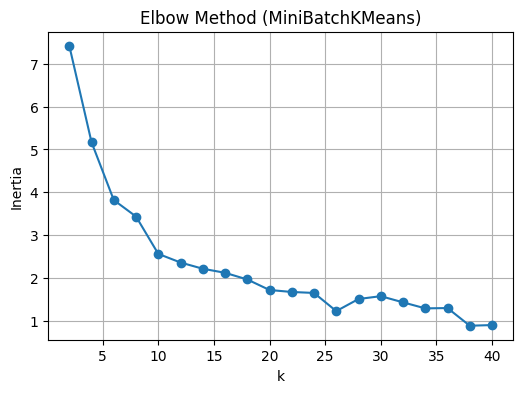

In [11]:
k_values = range(2, 41, 2)
inertias = []

for k in tqdm(k_values):
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=64, random_state=42)
    labels = mbk.fit_predict(X)
    inertias.append(mbk.inertia_)

# Graficar Elbow
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method (MiniBatchKMeans)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [12]:
n_clusters = 10

mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=64, random_state=42)
df_event.loc[:,'state_id'] = mbk.fit_predict(X)

display(df_event)

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,...,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A,state_embedding,state_id
1418110,1.748404e+09,route-views.eqix,6057,206.126.236.189,A,156.227.32.0/21,206.126.236.189,6057 6461 3491 150684 138195 133522,133522,6,...,6,NaN,NaN,1,0,"[-0.015436421, -0.034734137, -0.08241646, 0.00...",None,NaN,"[-0.0041357153, 0.013522448, -0.098932154, 0.0...",9
1418111,1.748404e+09,route-views.eqix,8220,206.126.238.64,A,156.227.32.0/21,206.126.238.64,8220 1299 3491 150684 138195 133522,133522,6,...,6,0.0,0.0,1,0,"[-0.03445172, -0.03765365, -0.06819371, 0.0180...","[-0.015436421, -0.034734137, -0.08241646, 0.00...",0.123257,"[-0.0039059862, 0.009959294, -0.08870342, 0.01...",9
1418112,1.748405e+09,route-views.eqix,16552,206.126.238.92,A,156.227.32.0/21,206.126.238.92,16552 1299 3491 150684 138195 133522,133522,6,...,6,0.0,0.0,1,0,"[-0.06269697, -0.04937925, 0.01215516, -0.0382...","[-0.03445172, -0.03765365, -0.06819371, 0.0180...",0.271987,"[-0.009323231, 0.015897159, -0.069182985, 0.00...",8
1418113,1.748405e+09,route-views.eqix,57695,206.126.236.214,A,156.227.32.0/21,206.126.236.214,57695 60068 174 3491 150684 138195 133522,133522,7,...,7,1.0,1.0,1,0,"[0.027108384, -0.035051804, -0.099397674, 0.01...","[-0.06269697, -0.04937925, 0.01215516, -0.0382...",0.406318,"[0.0007613517, 0.0076228185, -0.09350564, 0.01...",1
1418114,1.748405e+09,route-views.eqix,11039,206.126.236.172,A,156.227.32.0/21,206.126.236.172,11039 6461 3491 150684 138195 133522,133522,6,...,6,-1.0,-1.0,1,0,"[-0.07119129, -0.025156064, -0.05836838, -0.02...","[0.027108384, -0.035051804, -0.099397674, 0.01...",0.247136,"[-0.014641215, 0.01910438, -0.09241671, 0.0033...",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418647,1.748405e+09,route-views.ny,209823,206.82.105.109,W,156.227.32.0/21,None,None,None,0,...,0,NaN,NaN,1,0,None,None,NaN,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
1418648,1.748405e+09,route-views.eqix,6057,206.126.236.189,W,156.227.32.0/21,None,None,None,0,...,0,NaN,NaN,1,0,None,None,NaN,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
1418649,1.748405e+09,route-views.eqix,11039,206.126.236.172,W,156.227.32.0/21,None,None,None,0,...,0,NaN,NaN,1,0,None,None,NaN,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
1418650,1.748405e+09,route-views.ny,398465,206.82.104.185,A,156.227.32.0/21,206.82.104.185,398465 7029 6461 3491 150684 138195 133522,133522,7,...,7,0.0,0.0,1,0,"[-0.010729912, -0.04826849, -0.09244486, -0.01...","[-0.016531646, -0.07118929, -0.08040959, -0.02...",0.106572,"[-0.0071761897, 0.016782993, -0.09739853, 0.01...",1


In [ ]:
import joblib

joblib.dump(mbk, r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\states\best_mini_batch_k_means_prefix_137_59_18_0_24_k_18.pkl')

In [13]:
df_train = df_event[['time','prefix','origin','as_path','state_embedding','state_id']].reset_index(drop=True)
display(df_train)

,time,prefix,origin,as_path,state_embedding,state_id
0,1.748404e+09,156.227.32.0/21,133522,6057 6461 3491 150684 138195 133522,"[-0.0041357153, 0.013522448, -0.098932154, 0.0...",9
1,1.748404e+09,156.227.32.0/21,133522,8220 1299 3491 150684 138195 133522,"[-0.0039059862, 0.009959294, -0.08870342, 0.01...",9
2,1.748405e+09,156.227.32.0/21,133522,16552 1299 3491 150684 138195 133522,"[-0.009323231, 0.015897159, -0.069182985, 0.00...",8
3,1.748405e+09,156.227.32.0/21,133522,57695 60068 174 3491 150684 138195 133522,"[0.0007613517, 0.0076228185, -0.09350564, 0.01...",1
4,1.748405e+09,156.227.32.0/21,133522,11039 6461 3491 150684 138195 133522,"[-0.014641215, 0.01910438, -0.09241671, 0.0033...",9
...,...,...,...,...,...,...
537,1.748405e+09,156.227.32.0/21,None,None,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
538,1.748405e+09,156.227.32.0/21,None,None,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
539,1.748405e+09,156.227.32.0/21,None,None,"[-0.020649327, -0.0031331854, -0.067164764, 0....",0
540,1.748405e+09,156.227.32.0/21,133522,398465 7029 6461 3491 150684 138195 133522,"[-0.0071761897, 0.016782993, -0.09739853, 0.01...",1


### Generación del modelo

In [14]:
df_train['next_state_id'] = df_train['state_id'].shift(-1)

df_transitions = df_train.dropna(subset=['next_state_id']).copy()

df_transitions['next_state_id'] = df_transitions['next_state_id'].astype(int)

# Contar frecuencia de cada transición
transition_counts = (
    df_transitions.groupby(["state_id", "next_state_id"])
    .size()
    .unstack(fill_value=0)
)

# Normalizar por fila → P(j | i) Matrix de probabilidad de transición entre estados
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

transition_matrix

next_state_id,0,1,2,3,4,5,6,7,8,9
state_id,,,,,,,,,,
0,0.417323,0.283465,0.031496,0.023622,0.094488,0.047244,0.023622,0.015748,0.023622,0.039370
1,0.362637,0.164835,0.021978,0.054945,0.054945,0.109890,0.076923,0.032967,0.021978,0.098901
2,0.176471,0.058824,0.117647,0.000000,0.058824,0.058824,0.058824,0.176471,0.000000,0.294118
3,0.333333,0.166667,0.000000,0.055556,0.166667,0.000000,0.055556,0.000000,0.055556,0.166667
4,0.083333,0.116667,0.050000,0.016667,0.133333,0.100000,0.233333,0.066667,0.000000,0.200000
5,0.105263,0.157895,0.000000,0.035088,0.140351,0.122807,0.157895,0.000000,0.035088,0.245614
6,0.140625,0.062500,0.046875,0.031250,0.140625,0.156250,0.218750,0.046875,0.031250,0.125000
7,0.111111,0.037037,0.074074,0.000000,0.148148,0.185185,0.037037,0.296296,0.037037,0.074074
8,0.230769,0.307692,0.000000,0.000000,0.153846,0.000000,0.230769,0.000000,0.000000,0.076923


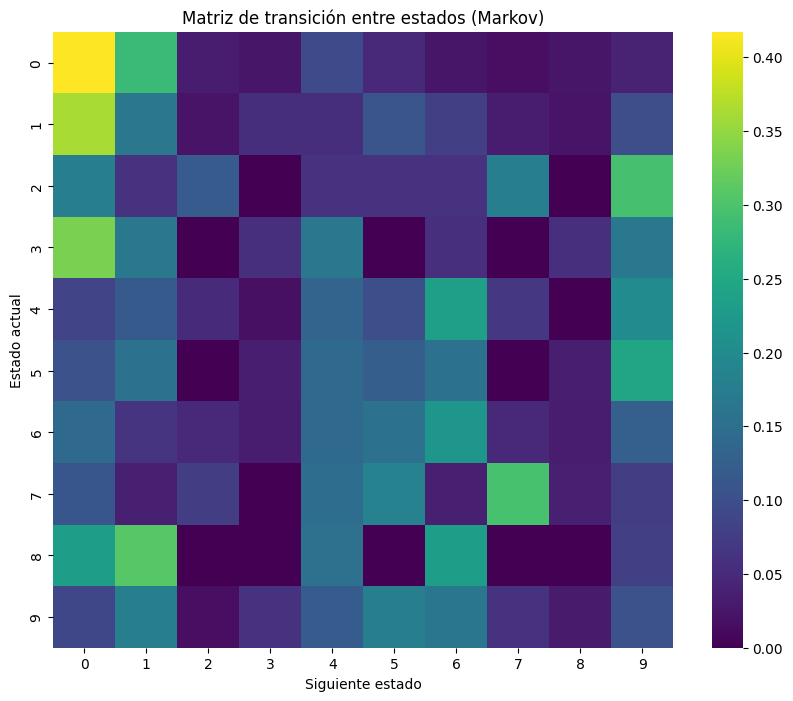

In [15]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, cmap="viridis", cbar=True)
plt.title("Matriz de transición entre estados (Markov)")
plt.xlabel("Siguiente estado")
plt.ylabel("Estado actual")
plt.show()

In [ ]:
joblib.dump(transition_matrix, r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\probs\best_transition_matrix_prefix_137_59_18_0_24_k_18.pkl')

## Inferencia

In [16]:
import numpy as np
import pandas as pd

import joblib
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

EMBEDDINGS_MODEL = 'sentence-transformers/all-MiniLM-L6-v2'

DATA_PATH = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\data\processed\Filtrado_Mayo_28_2025_output.parquet'

df = pd.read_parquet(DATA_PATH, engine="pyarrow")
display(df.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


In [17]:
def generate_state_embeddings(df: pd.DataFrame, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2') -> pd.DataFrame:
    """
    Genera embeddings (vectores numéricos) a partir de las columnas 'prefix' y 'as_path'
    y los almacena en una nueva columna llamada 'state_embedding'.
    
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada con al menos las columnas 'prefix' y 'as_path'.
    model_name : str, opcional
        Nombre del modelo SentenceTransformer a usar (por defecto: MiniLM-L6-v2).
    
    Retorna
    -------
    pd.DataFrame
        Copia del DataFrame original con la columna 'state_embedding' añadida.
    """

    # Hacemos una copia para no modificar el DataFrame original
    df_out = df.copy()

    # Cargamos el modelo de embeddings
    model = SentenceTransformer(model_name)

    # Filtramos filas válidas (sin valores nulos o vacíos en prefix/as_path)
    mask_valid = (
        df_out['prefix'].notna()
    )

    # Combinamos prefix + as_path en un solo texto (input para el modelo)
    df_out['state_text'] = df_out['type'].astype(str) + " " + df_out['prefix'].astype(str) + " " + df_out['origin'].astype(str) + " " + df_out['as_path'].astype(str)

    # Obtenemos los textos válidos a procesar
    valid_texts = df_out.loc[mask_valid, 'state_text'].tolist()

    # Generamos los embeddings (vectores de alta dimensión)
    embeddings = model.encode(valid_texts, show_progress_bar=True, convert_to_numpy=True)

    # Inicializamos la nueva columna
    df_out['state_embedding'] = None

    # Asignamos los embeddings solo a las filas válidas
    for i, idx in enumerate(df_out.index[mask_valid]):
        df_out.at[idx, 'state_embedding'] = embeddings[i]

    # Eliminamos la columna temporal 'state_text'
    df_out.drop(columns=['state_text'], inplace=True)
    df_out['state_embedding'].dropna(inplace=True)

    return df_out


### Prefijo 156.227.32.0/21

In [18]:
MBK_156_227_32_0_21 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\states\best_mini_batch_k_means_prefix_156_227_32_0_21_k_10.pkl'
TRANSITION_MATRIX_156_227_32_0_21 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\probs\best_transition_matrix_hijack_prefix_156_227_32_0_21_k_10.pkl'

PREFIX = '156.227.32.0/21'

mbk = joblib.load(MBK_156_227_32_0_21)
transition_matrix = joblib.load(TRANSITION_MATRIX_156_227_32_0_21)

df_inference = df[df['prefix']==PREFIX][['time','collector','type','prefix','origin','as_path']]
display(df.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


In [19]:
df_inference_embed = generate_state_embeddings(df_inference, EMBEDDINGS_MODEL)
display(df_inference_embed.head(5))

Batches: 100%|██████████| 62/62 [00:00<00:00, 62.43it/s]


,time,collector,type,prefix,origin,as_path,state_embedding
1418110,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,6057 6461 3491 150684 138195 133522,"[-0.0041357153, 0.013522448, -0.098932154, 0.0..."
1418111,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,8220 1299 3491 150684 138195 133522,"[-0.0039059862, 0.009959294, -0.08870342, 0.01..."
1418112,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,16552 1299 3491 150684 138195 133522,"[-0.009323231, 0.015897159, -0.069182985, 0.00..."
1418113,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,57695 60068 174 3491 150684 138195 133522,"[0.00076137634, 0.007622741, -0.093505695, 0.0..."
1418114,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,11039 6461 3491 150684 138195 133522,"[-0.014641215, 0.01910438, -0.09241671, 0.0033..."


#### Generación de los estados a partir del entrenamiento

In [20]:
X = np.vstack(df_inference_embed['state_embedding'].values)
print("Shape:", X.shape)

df_inference_embed.loc[:,'state_id'] = mbk.predict(X)
display(df_inference_embed.head(5))

Shape: (1974, 384)


,time,collector,type,prefix,origin,as_path,state_embedding,state_id
1418110,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,6057 6461 3491 150684 138195 133522,"[-0.0041357153, 0.013522448, -0.098932154, 0.0...",0
1418111,1.748404e+09,route-views.eqix,A,156.227.32.0/21,133522,8220 1299 3491 150684 138195 133522,"[-0.0039059862, 0.009959294, -0.08870342, 0.01...",0
1418112,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,16552 1299 3491 150684 138195 133522,"[-0.009323231, 0.015897159, -0.069182985, 0.00...",5
1418113,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,57695 60068 174 3491 150684 138195 133522,"[0.00076137634, 0.007622741, -0.093505695, 0.0...",4
1418114,1.748405e+09,route-views.eqix,A,156.227.32.0/21,133522,11039 6461 3491 150684 138195 133522,"[-0.014641215, 0.01910438, -0.09241671, 0.0033...",0


#### Obtener probabilidades

In [21]:
df_inferences = (
    df_inference_embed[["time", "state_id"]]
    .reset_index(drop=True)
)

# Siguiente estado (shift -1)
df_inferences["next_state_id"] = df_inferences["state_id"].shift(-1).fillna(-1).astype(int)
display(df_inferences.head(5))

,time,state_id,next_state_id
0,1.748404e+09,0,0
1,1.748404e+09,0,5
2,1.748405e+09,5,4
3,1.748405e+09,4,0
4,1.748405e+09,0,5


In [22]:
# Serie con las probabilidades P(j|i) de la matriz de transición
#    (MultiIndex: (state_i, state_j) -> prob)
probs_series = transition_matrix.stack()
probs_series

state_id  next_state_id
0         0                0.239130
          1                0.086957
          2                0.043478
          3                0.032609
          4                0.304348
                             ...   
9         5                0.037037
          6                0.185185
          7                0.000000
          8                0.000000
          9                0.296296
Length: 100, dtype: float64

In [23]:
# 4) Construimos las llaves (i, j) para cada fila y mapeamos en vector
keys = pd.MultiIndex.from_arrays(
    [df_inferences["state_id"], df_inferences["next_state_id"]]
)

df_inferences["trans_prob"] = probs_series.reindex(keys).to_numpy()

# 5) Limpieza:
#    - La última fila no tiene next_state_id -> NaN
#    - Transiciones nunca vistas -> NaN -> 0.0
df_inferences["trans_prob"] = df_inferences["trans_prob"].fillna(0.0)

display(df_inferences)

,time,state_id,next_state_id,trans_prob
0,1.748404e+09,0,0,0.239130
1,1.748404e+09,0,5,0.021739
2,1.748405e+09,5,4,0.461538
3,1.748405e+09,4,0,0.149425
4,1.748405e+09,0,5,0.021739
...,...,...,...,...
1969,1.748408e+09,8,0,0.083333
1970,1.748408e+09,0,8,0.054348
1971,1.748408e+09,8,8,0.083333
1972,1.748408e+09,8,8,0.083333


Negative Log-Likelihood (NLL)

$ NLL=−t∑​logP(st+1​∣st​) $

Mide qué tan bien un modelo probabilístico explica los datos observados, representa el grado de "sorpresa" del modelo ante las transiciones entre estados, entre mayor el valor, refleja menor probabilidad o anomalía.

In [24]:
# Score de anomalía: NLL por transición
eps = 1e-12 # Evita el log(0)
df_inferences["nll"] = -np.log(df_inferences["trans_prob"].clip(lower=eps)) # -log(P(st+1|st))

display(df_inferences)

,time,state_id,next_state_id,trans_prob,nll
0,1.748404e+09,0,0,0.239130,1.430746
1,1.748404e+09,0,5,0.021739,3.828641
2,1.748405e+09,5,4,0.461538,0.773190
3,1.748405e+09,4,0,0.149425,1.900959
4,1.748405e+09,0,5,0.021739,3.828641
...,...,...,...,...,...
1969,1.748408e+09,8,0,0.083333,2.484907
1970,1.748408e+09,0,8,0.054348,2.912351
1971,1.748408e+09,8,8,0.083333,2.484907
1972,1.748408e+09,8,8,0.083333,2.484907


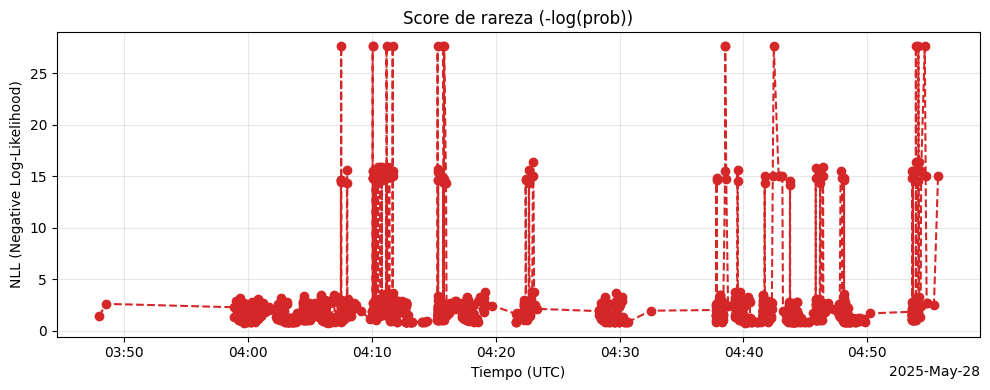

In [25]:
window = 2

df_inferences['nll_smooth'] = df_inferences['nll'].rolling(window=window, min_periods=1).mean()

df_inferences['time_dt'] = pd.to_datetime(df_inferences['time'], unit='s', utc=True)

df_inferences = df_inferences.sort_values('time_dt')

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)

# Grafica nll en su propio plot
fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(df_inferences['time_dt'], df_inferences['nll_smooth'], color='tab:red', linestyle='--', marker='o')
ax2.set_title("Score de rareza (-log(prob))")
ax2.set_xlabel("Tiempo (UTC)")
ax2.set_ylabel("NLL (Negative Log-Likelihood)")
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

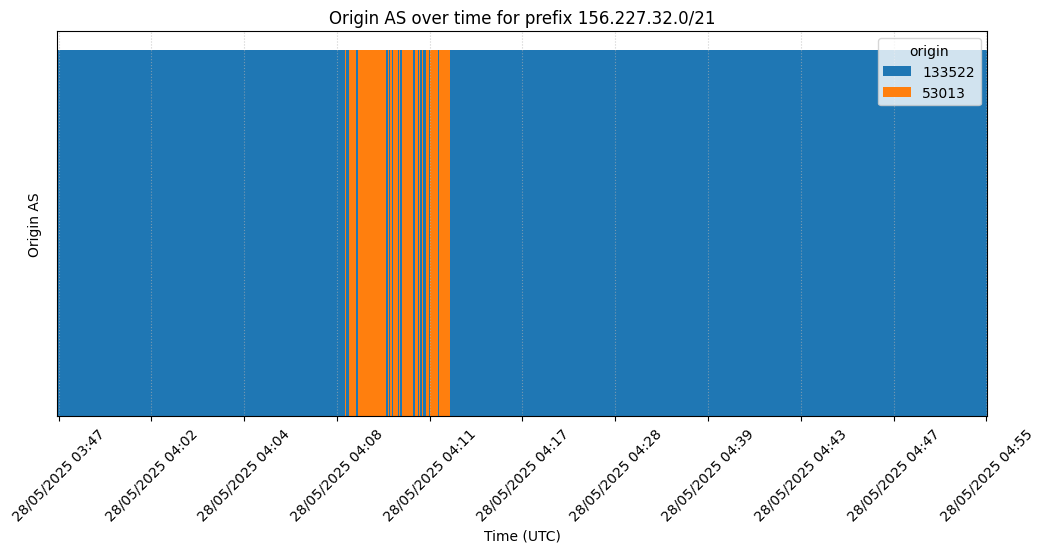

### Prefijo 137.59.18.0/24

In [26]:
MBK_137_59_18_0_24 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\states\best_mini_batch_k_means_prefix_137_59_18_0_24_k_18.pkl'
TRANSITION_MATRIX_137_59_18_0_24 = r'C:\Users\chris\Documents\Code\MNA\Proyecto_integrador\BGP-Hijacking-detection\models\markov\probs\best_transition_matrix_prefix_137_59_18_0_24_k_18.pkl'

PREFIX = '137.59.18.0/24'

mbk = joblib.load(MBK_137_59_18_0_24)
transition_matrix = joblib.load(TRANSITION_MATRIX_137_59_18_0_24)

df_inference = df[df['prefix']==PREFIX][['time','collector','type','prefix','origin','as_path']]
display(df.head(5))

,time,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,as_path_length,secs_between_announcements,unique_as_in_path,as_path_length_diff_A,as_path_length_diff_A_abs,origin_at_time_nuniq,MOAS,as_path_embedding,prev_embedding,cosine_distance_prev_A
23695,1.748405e+09,route-views2.saopaulo,271253,187.16.209.243,A,101.32.0.0/20,187.16.209.243,271253 3356 52468 53013,53013,4,NaN,4,NaN,NaN,1,0,"[-0.11526176, -0.09743151, -0.020272827, 0.009...",None,NaN
23696,1.748405e+09,route-views2.saopaulo,263009,187.16.222.221,A,101.32.0.0/20,187.16.222.221,263009 3356 52468 53013,53013,4,5.567167,4,0.0,0.0,1,0,"[-0.109163135, -0.08994652, -0.033548128, 0.02...","[-0.11526176, -0.09743151, -0.020272827, 0.009...",0.110881
23697,1.748405e+09,route-views2.saopaulo,49544,187.16.220.229,A,101.32.0.0/20,187.16.220.229,49544 3356 52468 53013,53013,4,1.157437,4,0.0,0.0,1,0,"[-0.10434281, -0.12043201, 0.027555868, -0.002...","[-0.109163135, -0.08994652, -0.033548128, 0.02...",0.153625
23698,1.748405e+09,route-views2.saopaulo,199524,187.16.222.229,A,101.32.0.0/20,187.16.222.229,199524 3356 52468 53013,53013,4,0.606782,4,0.0,0.0,1,0,"[-0.145274, -0.024599299, 0.05076105, -0.01027...","[-0.10434281, -0.12043201, 0.027555868, -0.002...",0.252730
23699,1.748405e+09,route-views2.saopaulo,52468,187.16.208.180,W,101.32.0.0/20,None,None,None,0,NaN,0,NaN,NaN,1,0,None,None,NaN


In [27]:
df_inference_embed = generate_state_embeddings(df_inference, EMBEDDINGS_MODEL)
display(df_inference_embed.head(5))

Batches: 100%|██████████| 21/21 [00:00<00:00, 49.28it/s]


,time,collector,type,prefix,origin,as_path,state_embedding
719975,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,16552 2914 3786 138195 138195,"[-0.07483852, 0.059032775, -0.023612479, 0.028..."
719976,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,11039 4901 11164 3786 138195 138195,"[-0.07715189, 0.07551787, -0.03519158, 0.02309..."
719977,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6830 174 3786 138195 138195,"[-0.05049928, 0.06606932, -0.03694837, 0.03835..."
719978,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6939 3786 138195 138195,"[-0.059439927, 0.0695423, -0.030375622, 0.0366..."
719979,1.748405e+09,route-views.ny,A,137.59.18.0/24,138195,49544 3786 138195 138195,"[-0.052429806, 0.052830707, -0.028444333, 0.03..."


In [28]:
X = np.vstack(df_inference_embed['state_embedding'].values)
print("Shape:", X.shape)

df_inference_embed.loc[:,'state_id'] = mbk.predict(X)
display(df_inference_embed.head(5))

Shape: (655, 384)


,time,collector,type,prefix,origin,as_path,state_embedding,state_id
719975,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,16552 2914 3786 138195 138195,"[-0.07483852, 0.059032775, -0.023612479, 0.028...",6
719976,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,11039 4901 11164 3786 138195 138195,"[-0.07715189, 0.07551787, -0.03519158, 0.02309...",7
719977,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6830 174 3786 138195 138195,"[-0.05049928, 0.06606932, -0.03694837, 0.03835...",12
719978,1.748405e+09,route-views.eqix,A,137.59.18.0/24,138195,6939 3786 138195 138195,"[-0.059439927, 0.0695423, -0.030375622, 0.0366...",14
719979,1.748405e+09,route-views.ny,A,137.59.18.0/24,138195,49544 3786 138195 138195,"[-0.052429806, 0.052830707, -0.028444333, 0.03...",7


In [29]:
df_inferences = (
    df_inference_embed[["time", "state_id"]]
    .reset_index(drop=True)
)

# Siguiente estado (shift -1)
df_inferences["next_state_id"] = df_inferences["state_id"].shift(-1).fillna(-1).astype(int)
display(df_inferences.head(5))

,time,state_id,next_state_id
0,1.748405e+09,6,7
1,1.748405e+09,7,12
2,1.748405e+09,12,14
3,1.748405e+09,14,7
4,1.748405e+09,7,15


In [30]:
# Serie con las probabilidades P(j|i) de la matriz de transición
#    (MultiIndex: (state_i, state_j) -> prob)
probs_series = transition_matrix.stack()
probs_series

state_id  next_state_id
0         0                0.210526
          1                0.000000
          2                0.210526
          3                0.000000
          4                0.000000
                             ...   
17        13               0.000000
          14               0.000000
          15               0.000000
          16               0.000000
          17               0.000000
Length: 324, dtype: float64

In [31]:
# Construimos las llaves (i, j) para cada fila y mapeamos en vector
keys = pd.MultiIndex.from_arrays(
    [df_inferences["state_id"], df_inferences["next_state_id"]]
)

df_inferences["trans_prob"] = probs_series.reindex(keys).to_numpy()

# Limpieza:
#    - La última fila no tiene next_state_id -> NaN
#    - Transiciones nunca vistas -> NaN -> 0.0
df_inferences["trans_prob"] = df_inferences["trans_prob"].fillna(0.0)

display(df_inferences)

,time,state_id,next_state_id,trans_prob
0,1.748405e+09,6,7,0.200000
1,1.748405e+09,7,12,0.125000
2,1.748405e+09,12,14,0.166667
3,1.748405e+09,14,7,0.333333
4,1.748405e+09,7,15,0.062500
...,...,...,...,...
650,1.748408e+09,10,13,0.142857
651,1.748408e+09,13,10,0.000000
652,1.748408e+09,10,2,0.285714
653,1.748408e+09,2,2,0.142857


In [32]:
# Score de anomalía: NLL por transición
eps = 1e-12 # Evita el log(0)
df_inferences["nll"] = -np.log(df_inferences["trans_prob"].clip(lower=eps))

display(df_inferences)

,time,state_id,next_state_id,trans_prob,nll
0,1.748405e+09,6,7,0.200000,1.609438
1,1.748405e+09,7,12,0.125000,2.079442
2,1.748405e+09,12,14,0.166667,1.791759
3,1.748405e+09,14,7,0.333333,1.098612
4,1.748405e+09,7,15,0.062500,2.772589
...,...,...,...,...,...
650,1.748408e+09,10,13,0.142857,1.945910
651,1.748408e+09,13,10,0.000000,27.631021
652,1.748408e+09,10,2,0.285714,1.252763
653,1.748408e+09,2,2,0.142857,1.945910


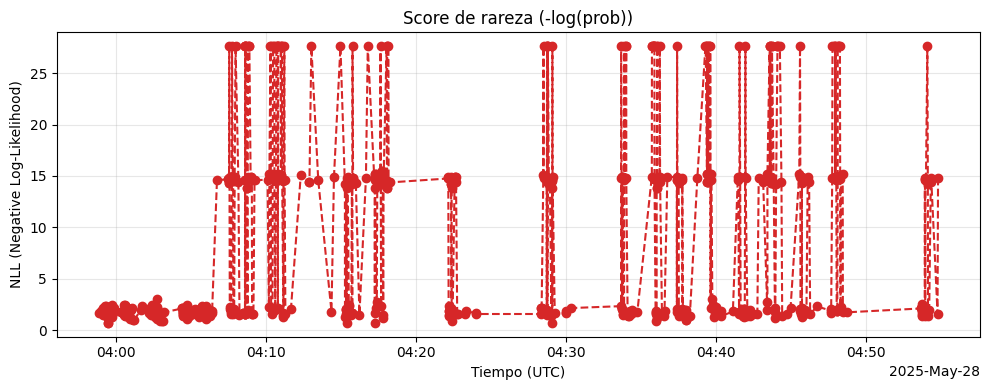

In [33]:
window = 2

df_inferences['nll_smooth'] = df_inferences['nll'].rolling(window=window, min_periods=1).mean()

df_inferences['time_dt'] = pd.to_datetime(df_inferences['time'], unit='s', utc=True)

df_inferences = df_inferences.sort_values('time_dt')

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)

# Grafica nll en su propio plot
fig, ax2 = plt.subplots(figsize=(10, 4))
ax2.plot(df_inferences['time_dt'], df_inferences['nll_smooth'], color='tab:red', linestyle='--', marker='o')
ax2.set_title("Score de rareza (-log(prob))")
ax2.set_xlabel("Tiempo (UTC)")
ax2.set_ylabel("NLL (Negative Log-Likelihood)")
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

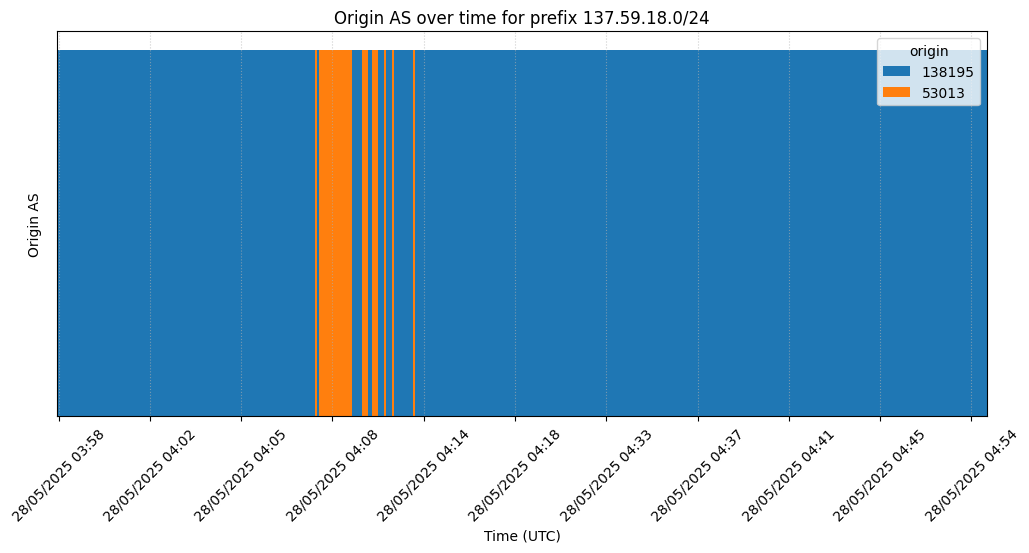

# Conclusiones

En el estudio del BGP hijacking, nuestro trabajo ha explorado distintos modelos secuenciales para detectar comportamientos anómalos en la propagación de rutas. Las cadenas de Markov se han mostrado particularmente útiles al modelar la probabilidad de transición entre sistemas autónomos (AS) y calcular un Score de rareza (Negative Log-Likelihood, NLL), el cual mide qué tan improbable resulta una secuencia con respecto al comportamiento histórico. Este score ha sido clave para detectar anomalías reales, ya que permite identificar eventos atípicos, como prefijos que cambian inesperadamente de origen o trayectorias que no se habían observado antes.
En contraste, los modelos basados en redes neuronales recurrentes (RNN) y sus variantes LSTM y GRU, aunque teóricamente más potentes al capturar dependencias de largo plazo, mostraron signos de sobreentrenamiento, presentando un alto desempeño en los datos de entrenamiento pero una capacidad limitada para generalizar a nuevas observaciones.

**MSE:**
| **MODELO** | **ENTRENAMIENTO** | **VALIDACIÓN** | **PRUEBA** |
|    ---     |        ---        |      ---       |     ---    |
|    GRU     |        0.003939        |      0.003939       |     0.004926    |
|    LSTM     |        0.000880        |      0.001239       |     0.000972    |

En la comparación entre ambos modelos, el LSTM mostró un desempeño superior al GRU, al obtener valores de error notablemente más bajos en entrenamiento, validación y prueba. Esto indica que el LSTM logra una mejor capacidad de generalización y estabilidad al modelar las secuencias.

 Actualmente continuamos en la búsqueda de hiperparámetros óptimos que permitan mejorar su desempeño, equilibrando sensibilidad y robustez. En conjunto, la combinación de un modelo probabilístico interpretable (como el de Markov) con técnicas neuronales ajustadas representa una línea prometedora para fortalecer la detección de anomalías BGP en entornos reales y dinámicos.